In [2]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import numpy as np
import matplotlib.patches as mpatches

# KMeans

In [3]:
def kmeans_clustering(datasets):
    
    cluster_range = range(2, 11)
    results = {ngram: {"clusters": [], "silhouette": [], "calinski": [], "davies": []} for ngram in datasets}
    labels = []

    for ngram, data in datasets.items():
        data_numeric = data.iloc[:, 2:] 

        for k in cluster_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(data_numeric)
            labels = kmeans.labels_
            results[ngram]["clusters"].append(k)
            results[ngram]["silhouette"].append(silhouette_score(data_numeric, labels))
            results[ngram]["calinski"].append(calinski_harabasz_score(data_numeric, labels))
            results[ngram]["davies"].append(davies_bouldin_score(data_numeric, labels))

    # Plotting metrics
    fig, axes = plt.subplots(len(datasets), 3, figsize=(18, 4 * len(datasets)))
    if len(datasets) == 1:
        axes = [axes]

    metrics = ["silhouette", "calinski", "davies"]

    for i, (ngram, scores) in enumerate(results.items()):
        for j, metric in enumerate(metrics):
            ax = axes[i][j] if len(datasets) > 1 else axes[j]
            ax.plot(scores["clusters"], scores[metric], marker='o')
            ax.set_title(f"{ngram} - {metric}")
            ax.set_xlabel("Broj klastera")
            ax.set_ylabel(metric.capitalize())

    plt.tight_layout()
    plt.show()


In [82]:
df3 = pd.read_csv("../csv_data/3gram_matrix_amino_acid_combined.csv")
df4 = pd.read_csv("../csv_data/4gram_matrix_amino_acid_combined.csv")
df5 = pd.read_csv("../csv_data/5gram_matrix_amino_acid_combined.csv")
datasets = {"3-gram": df3, "4-gram": df4, "5-gram": df5}

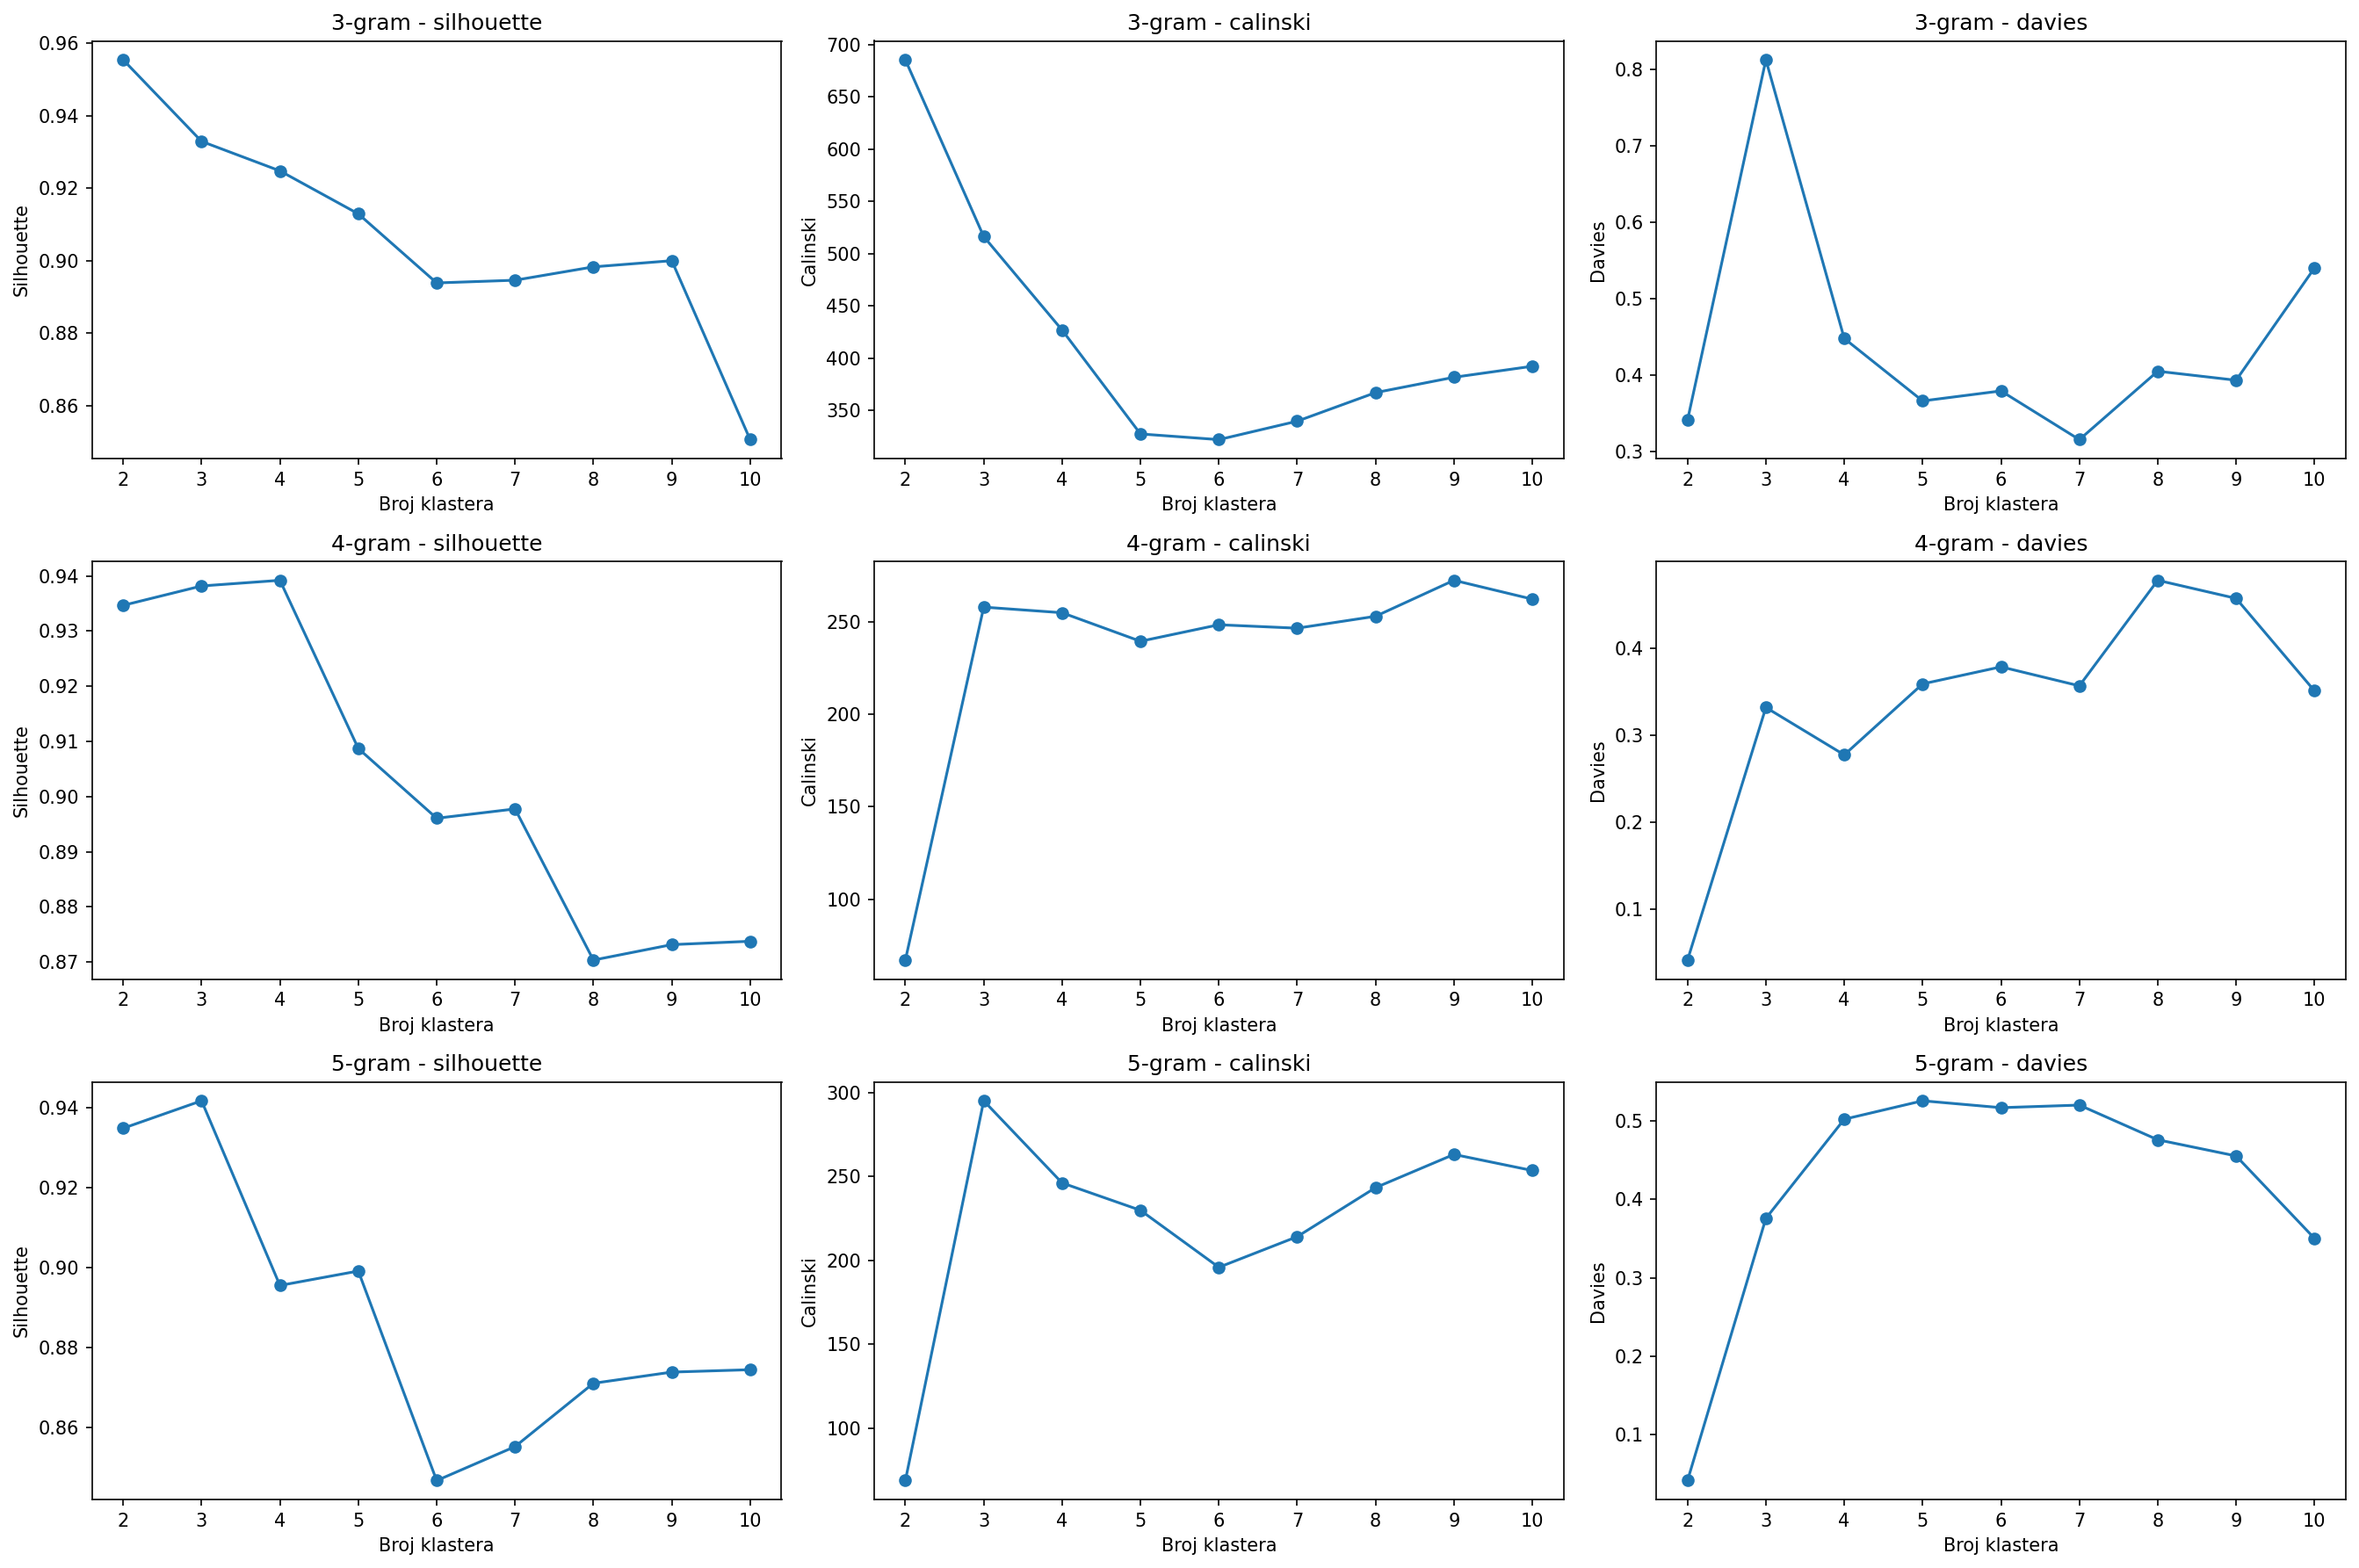

In [83]:
kmeans_clustering(datasets)

In [ ]:
def visualize_clusters_only(datasets, label_key="virus_type", k=2):

    n_plots = len(datasets)
    fig, axs = plt.subplots(1, n_plots, figsize=(18, 5))

    if n_plots == 1:
        axs = [axs]

    for ax, (label, df) in zip(axs, datasets.items()):
        labels = df[label_key]
        numeric_data = df.iloc[:, 2:]

        pca = PCA(n_components=2, random_state=42)
        pca.fit(numeric_data.values)
        reduced_data = pca.transform(numeric_data.values)

        # KMeans
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        clusters = kmeans.fit_predict(numeric_data.values)
        centers_2d = pca.transform(kmeans.cluster_centers_)

        # Boje po labeli (virus_type, protein_type...)
        color_vals = pd.factorize(labels)[0]
        cmap = cm.rainbow(np.linspace(0, 1, len(np.unique(color_vals))))

        ax.scatter(
            reduced_data[:, 0], reduced_data[:, 1],
            c=color_vals,
            cmap=cm.rainbow,
            s=80, edgecolor='k'
        )

        # Klasteri kao crni X
        ax.scatter(
            centers_2d[:, 0], centers_2d[:, 1],
            marker='x', c='black', s=150, linewidths=3, label='Cluster centroid'
        )

        ax.set_title(f"{label} – klasteri i '{label_key}'", fontsize=14)
        ax.set_xlabel("PCA 1", fontsize=12)
        ax.set_ylabel("PCA 2", fontsize=12)
        ax.set_aspect('equal')

    plt.tight_layout()
    plt.show()

In [85]:
def draw_legend_for_labels(datasets, label_key="virus_type"):

    all_labels = pd.concat([df[label_key] for df in datasets.values()])
    unique_labels = pd.Series(all_labels.unique())
    num_labels = len(unique_labels)
    cmap = cm.rainbow(np.linspace(0, 1, num_labels))

    ncol = 4
    n_rows = int(np.ceil(num_labels / ncol))
    fig_height = 0.6 + n_rows * 0.3

    fig, ax = plt.subplots(figsize=(12, fig_height))
    ax.axis('off')

    handles = [mpatches.Patch(color=cmap[i], label=unique_labels[i]) for i in range(num_labels)]
    ax.legend(
        handles=handles,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.0),
        fontsize=10,
        ncol=ncol,
        frameon=False
    )

    plt.subplots_adjust(top=1, bottom=0, left=0.05, right=0.95)
    plt.show()

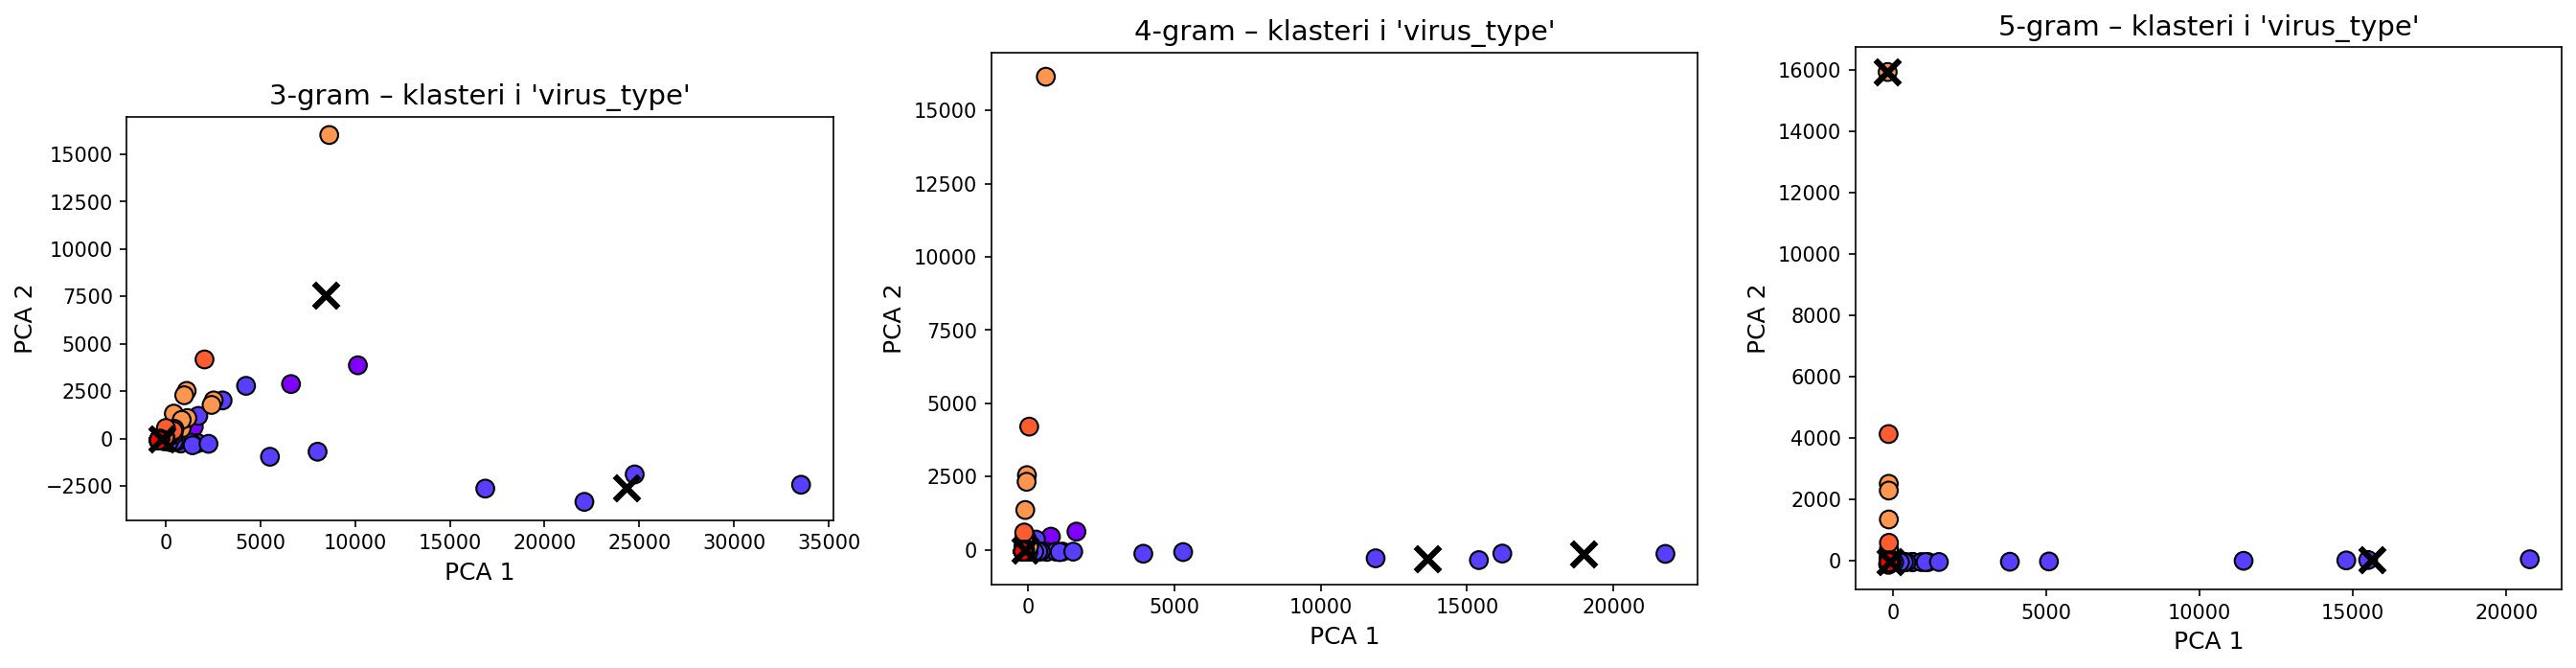

In [86]:
visualize_clusters_only(datasets, label_key="virus_type", k=3)

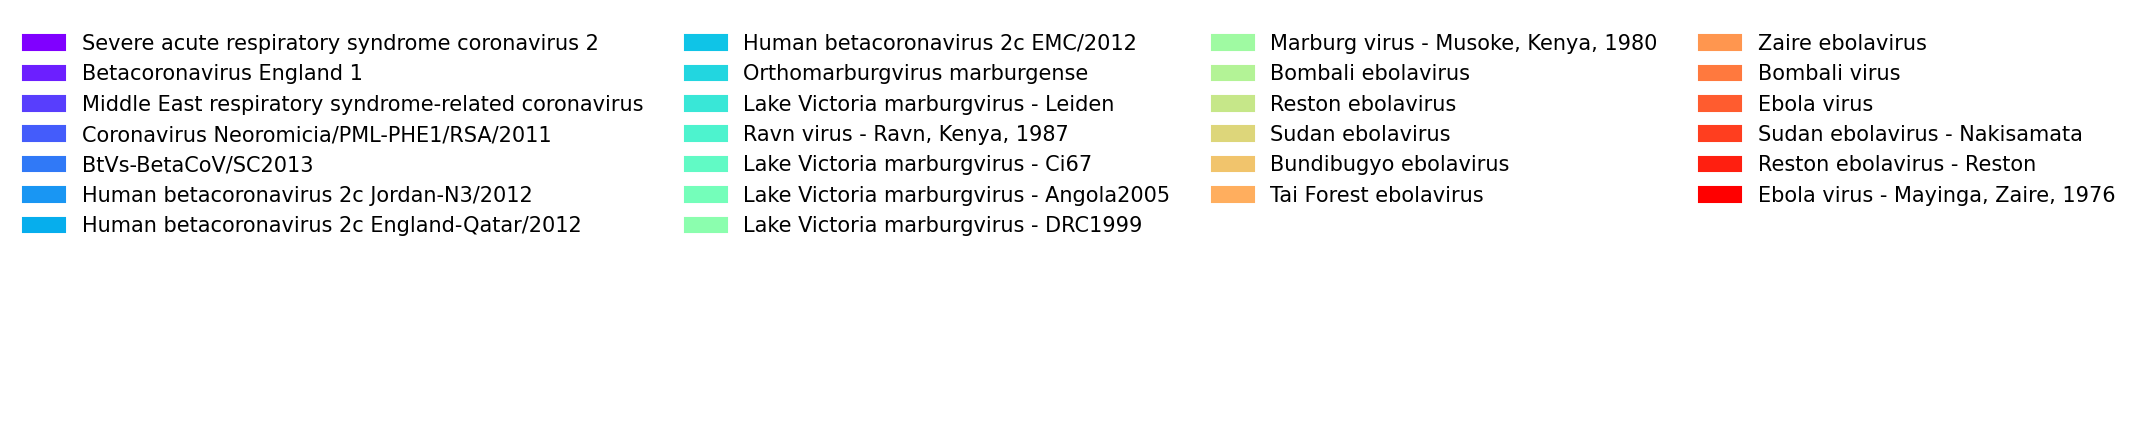

In [87]:
draw_legend_for_labels(datasets, label_key="virus_type")

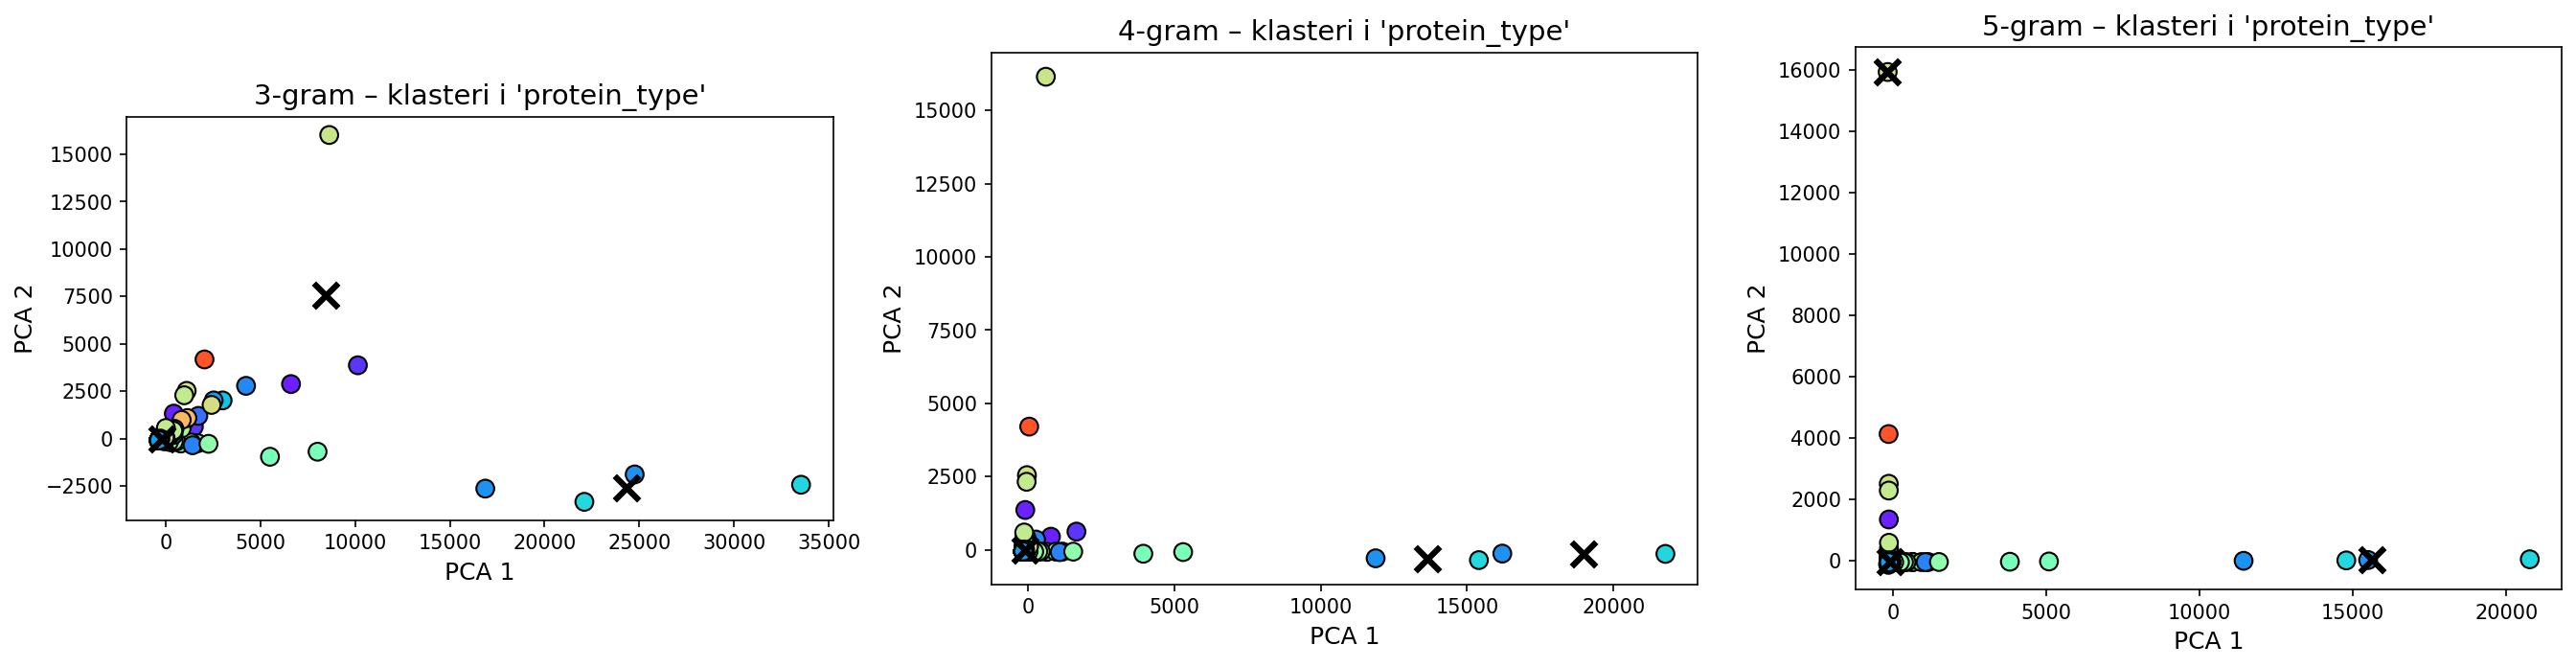

In [88]:
visualize_clusters_only(datasets, label_key="protein_type", k=3)

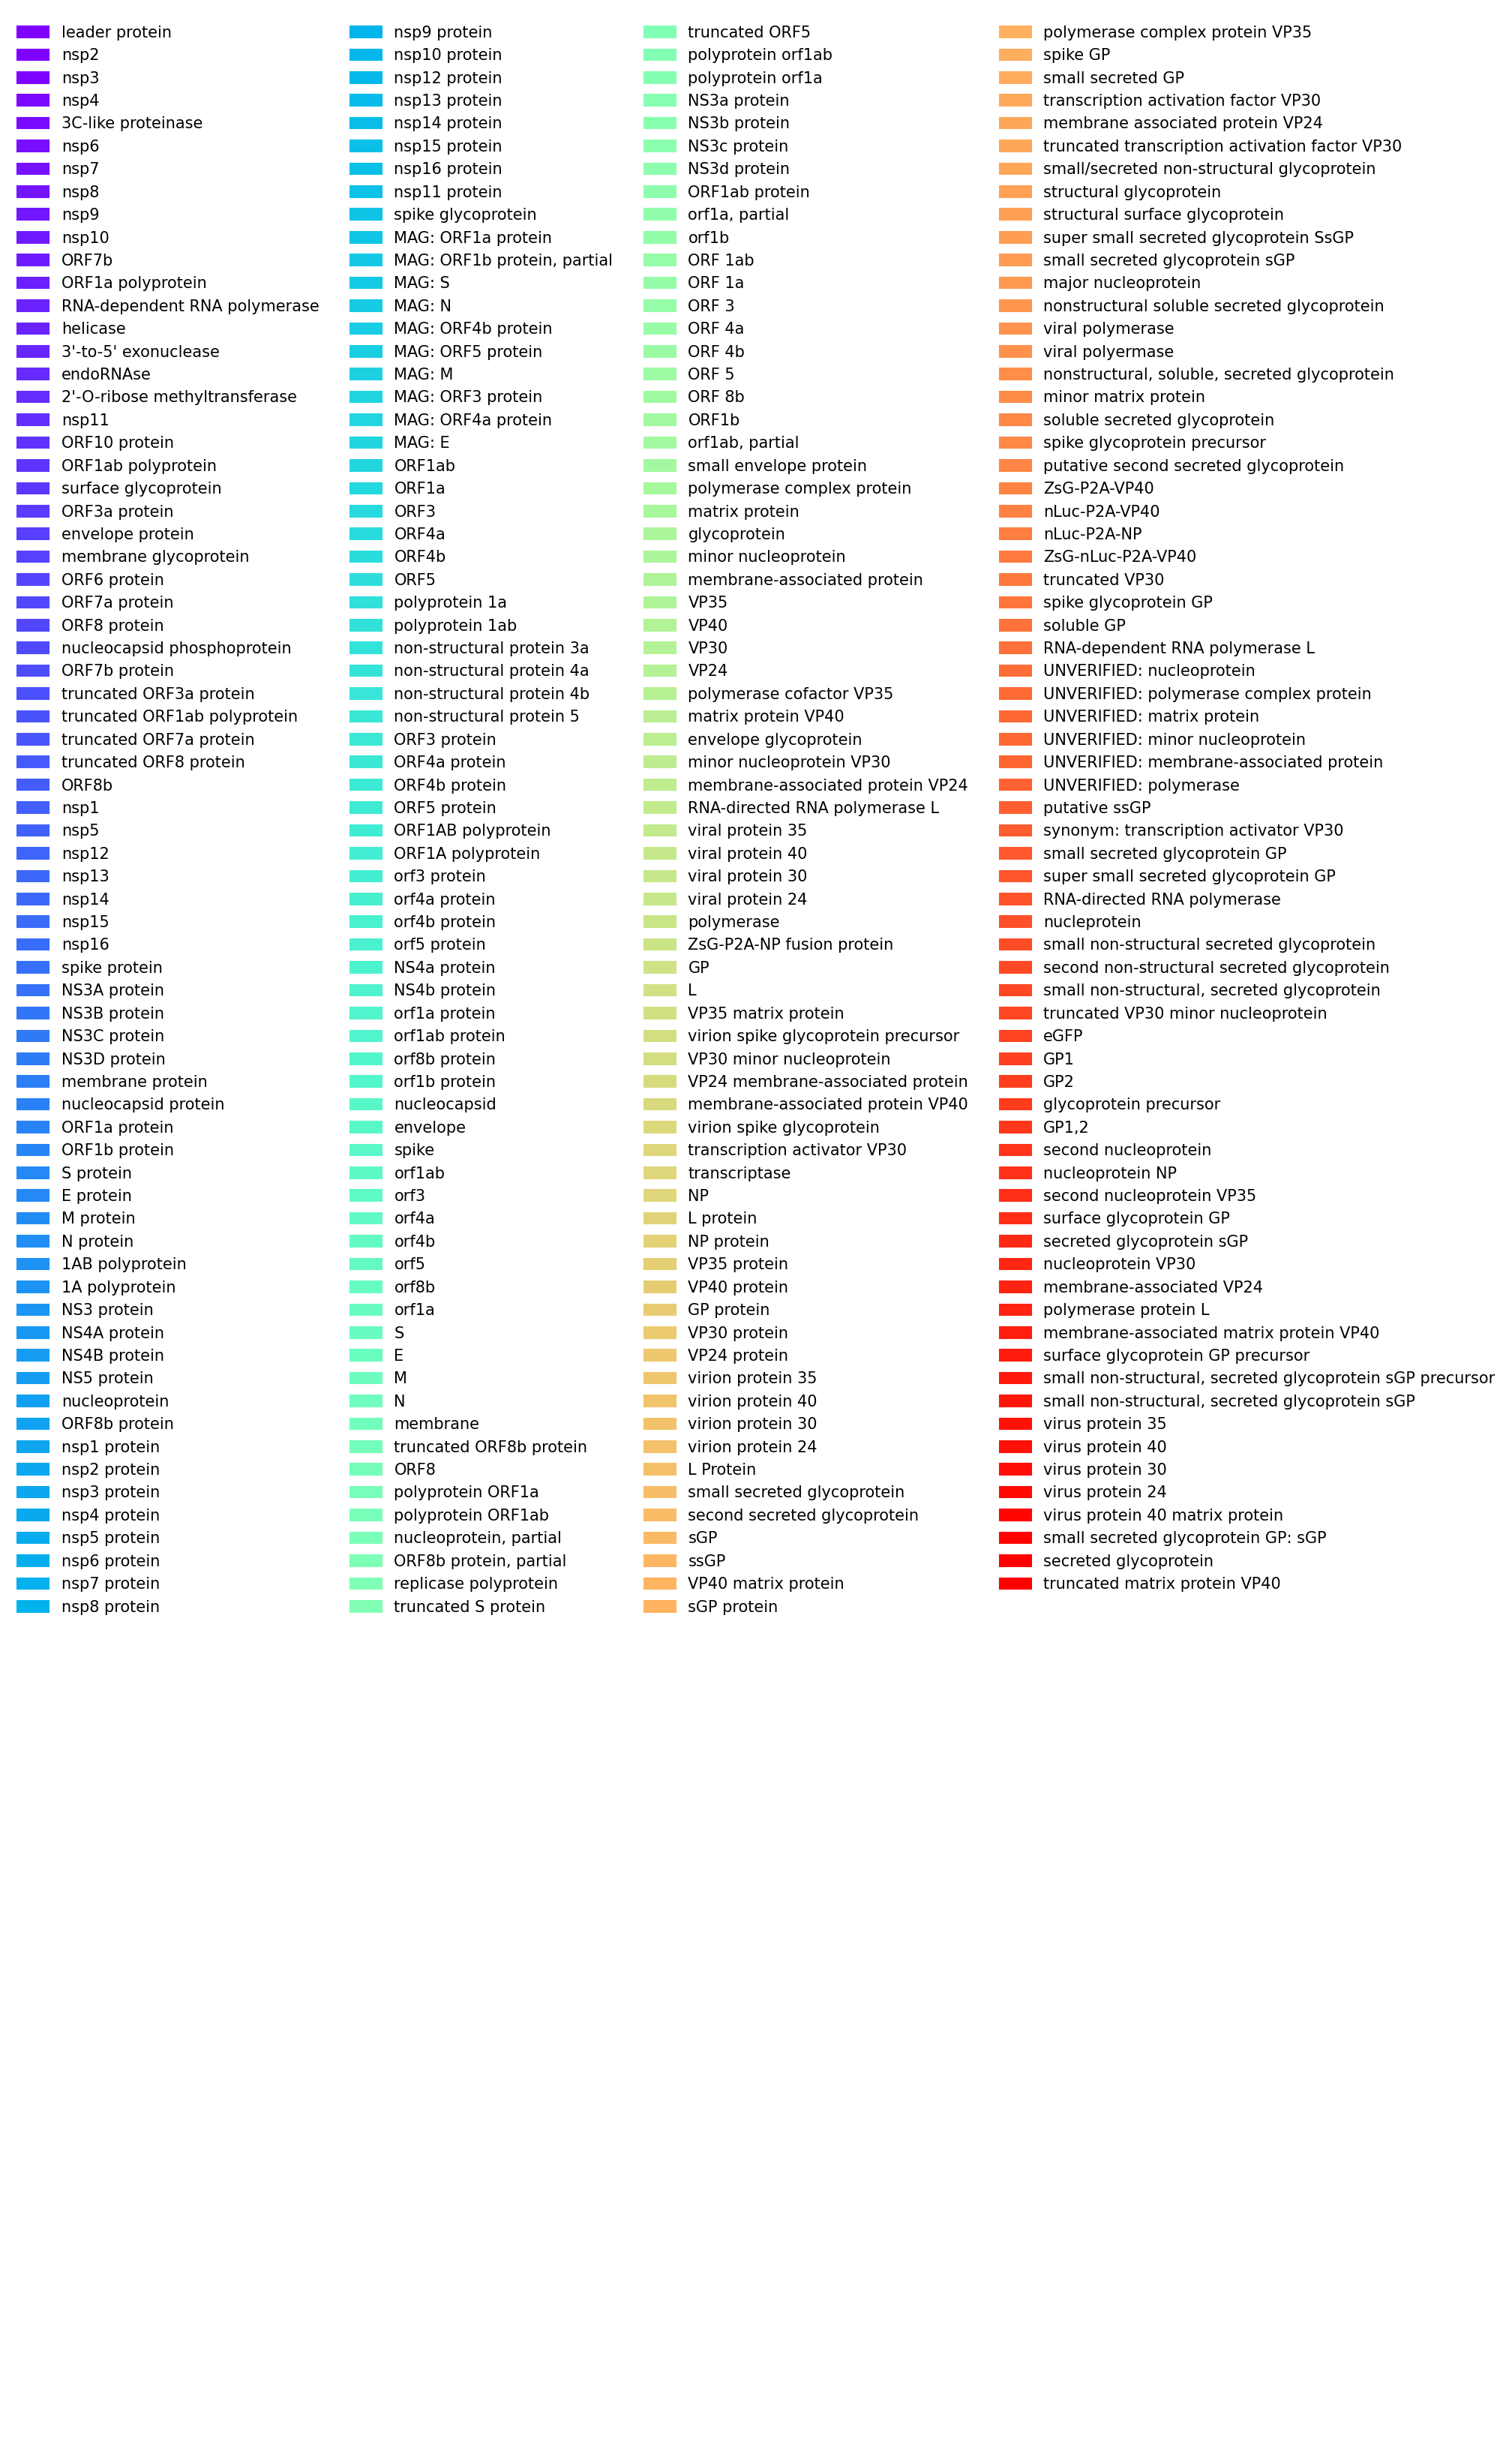

In [89]:
draw_legend_for_labels(datasets, label_key="protein_type")

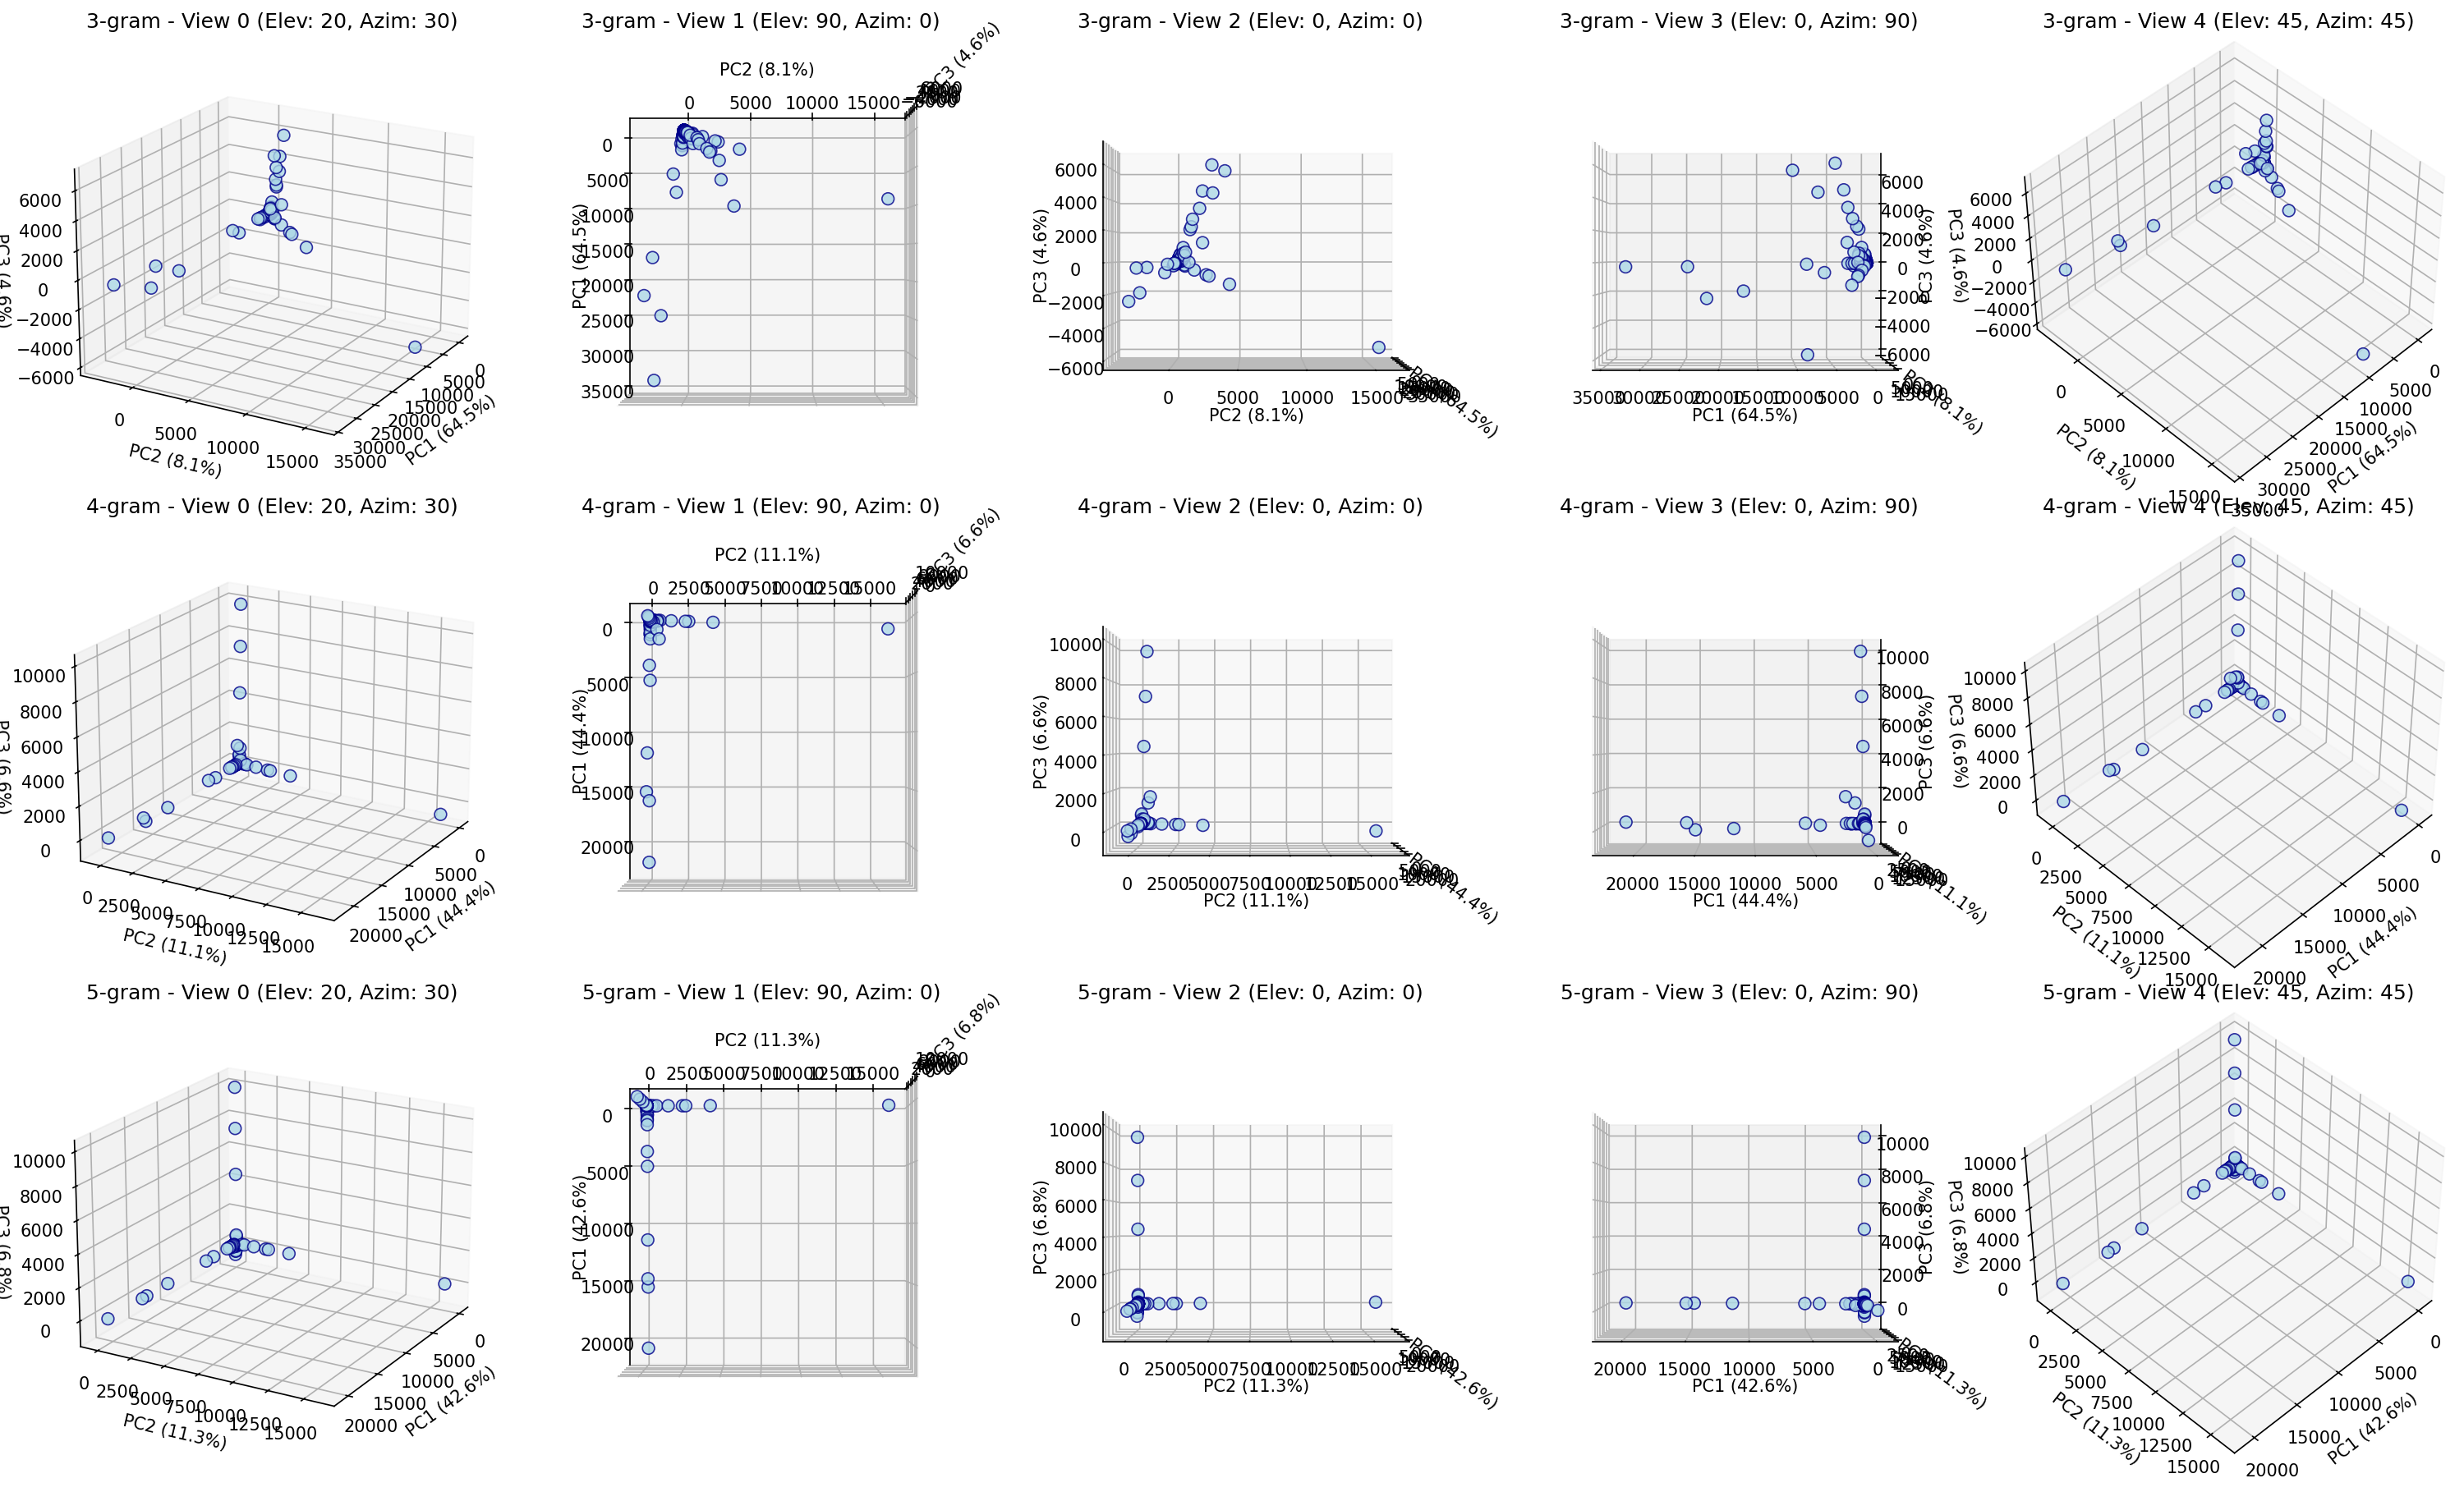

In [90]:
# Kreiraj figure i ose sa 3 reda i 5 kolona sa 3D projekcijom
fig, axes = plt.subplots(nrows=3, ncols=5, subplot_kw={"projection": "3d"}, figsize=(20, 12))

# Definiši različite poglede
viewpoints = [
    (20, 30),   # Default view
    (90, 0),    # Top-down view
    (0, 0),     # Front view
    (0, 90),    # Side view
    (45, 45)    # Isometric view
]

for i, (label, data) in enumerate(datasets.items()):
    numeric_data = data.select_dtypes(include=['number'])
    
    pca = PCA(n_components=3)
    principal_components = pca.fit_transform(numeric_data)
    explained_variance = pca.explained_variance_ratio_
    
    pca_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2', 'PC3'])
    
    for j, (elev, azim) in enumerate(viewpoints):
        ax = axes[i, j]
        ax.scatter(
            pca_df['PC1'], pca_df['PC2'], pca_df['PC3'],
            c='lightblue', edgecolors='darkblue', linewidth=0.8, alpha=0.8, s=50
        )
        
        ax.view_init(elev=elev, azim=azim)
        
        ax.set_title(f'{label} - View {j} (Elev: {elev}, Azim: {azim})')
        ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)')
        ax.set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)')
        ax.set_zlabel(f'PC3 ({explained_variance[2]*100:.1f}%)')

plt.tight_layout()
plt.show()

#  Hierarchical Clustering

In [6]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram

In [13]:
def hierarchical_clustering(datasets):
    cluster_range = range(2, 11)
    results = {ngram: {"clusters": [], "silhouette": [], "calinski": [], "davies": []} for ngram in datasets}
    
    # Grid search
    for ngram, data in datasets.items():
        
        data_numeric = data.iloc[:, 2:]
        
        for k in cluster_range:
            model = AgglomerativeClustering(n_clusters=k)
            labels = model.fit_predict(data_numeric)
            results[ngram]["clusters"].append(k)
            results[ngram]["silhouette"].append(silhouette_score(data_numeric, labels))
            results[ngram]["calinski"].append(calinski_harabasz_score(data_numeric, labels))
            results[ngram]["davies"].append(davies_bouldin_score(data_numeric, labels))
    
    # Plot metric scores for each n-gram
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    metrics = ["silhouette", "calinski", "davies"]
    
    for i, (ngram, scores) in enumerate(results.items()):
        for j, metric in enumerate(metrics):
            ax = axes[i, j]
            ax.plot(scores["clusters"], scores[metric], marker='o')
            ax.set_title(f"{ngram} - {metric}")
            ax.set_xlabel("Number of Clusters")
            ax.set_ylabel(metric.capitalize())
    
    plt.tight_layout()
    plt.show()

In [4]:
df3 = pd.read_csv("../csv_data/3gram_matrix_amino_acid_combined.csv")
df4 = pd.read_csv("../csv_data/4gram_matrix_amino_acid_combined.csv")
df5 = pd.read_csv("../csv_data/5gram_matrix_amino_acid_combined.csv")
datasets = {"3-gram": df3, "4-gram": df4, "5-gram": df5}

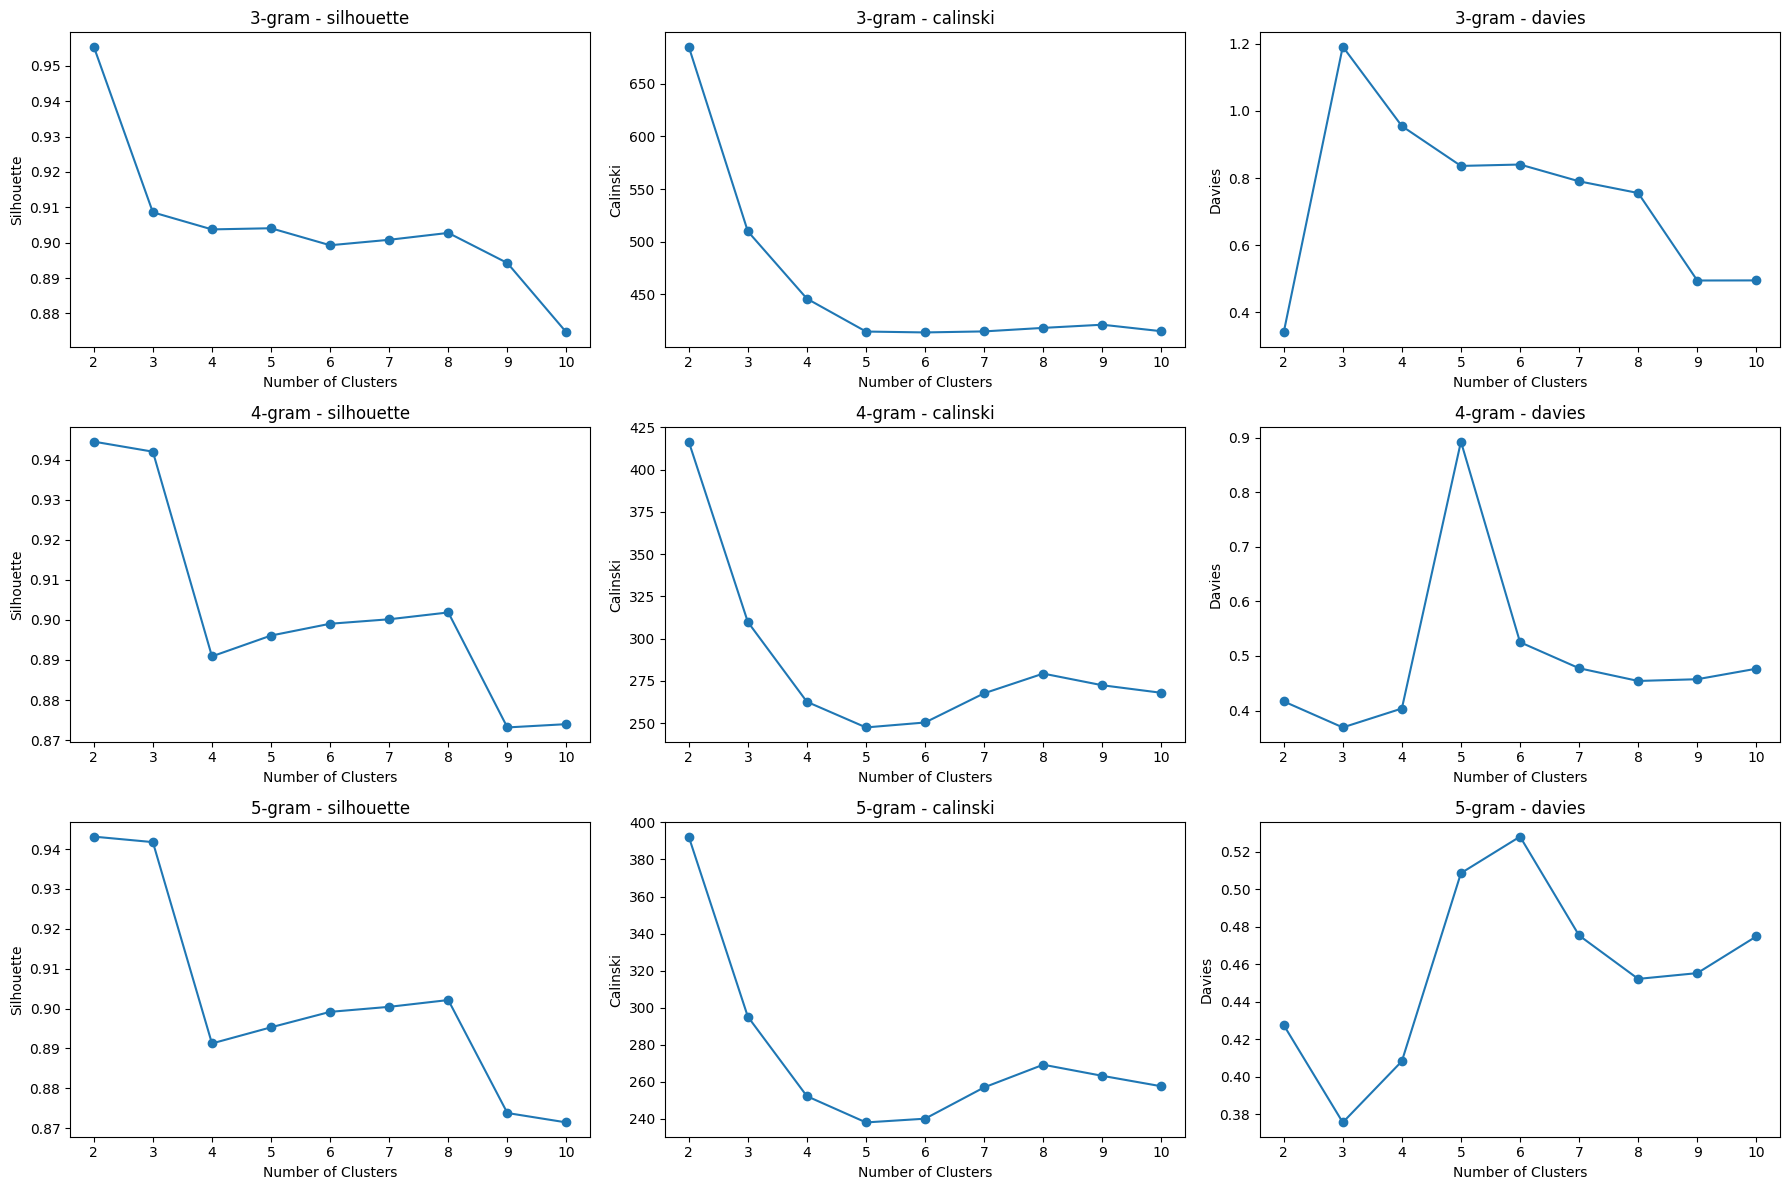

In [14]:
hierarchical_clustering(datasets)

In [41]:
def get_color_map_for_labels(datasets, label_key="virus_type"):
    all_labels = pd.concat([df[label_key] for df in datasets.values()])
    unique_labels = all_labels.unique()
    num_labels = len(unique_labels)
    cmap = cm.rainbow(np.linspace(0, 1, num_labels))
    color_map = dict(zip(unique_labels, cmap))
    return color_map

In [42]:
def visualize_clusters_only(datasets, label_key="virus_type", k=2):
    color_map = get_color_map_for_labels(datasets, label_key)

    n_plots = len(datasets)
    fig, axs = plt.subplots(1, n_plots, figsize=(18, 5))
    if n_plots == 1:
        axs = [axs]

    for ax, (label, df) in zip(axs, datasets.items()):
        labels = df[label_key]
        numeric_data = df.iloc[:, 2:]

        pca = PCA(n_components=2, random_state=42)
        reduced_data = pca.fit_transform(numeric_data.values)

        model = AgglomerativeClustering(n_clusters=k)
        clusters = model.fit_predict(numeric_data.values)

        centers = []
        for cluster_id in range(k):
            points_in_cluster = reduced_data[clusters == cluster_id]
            center = points_in_cluster.mean(axis=0)
            centers.append(center)
        centers_2d = np.array(centers)

        colors = labels.map(color_map)

        ax.scatter(
            reduced_data[:, 0], reduced_data[:, 1],
            c=colors,
            s=80, edgecolor='k'
        )

        ax.scatter(
            centers_2d[:, 0], centers_2d[:, 1],
            marker='x', c='black', s=150, linewidths=3, label='Cluster centroid'
        )

        ax.set_title(f"{label} – klasteri i '{label_key}'", fontsize=14)
        ax.set_xlabel("PCA 1", fontsize=12)
        ax.set_ylabel("PCA 2", fontsize=12)
        ax.set_aspect('equal')

    plt.tight_layout()
    plt.show()

In [43]:
def draw_legend_for_labels(datasets, label_key="virus_type"):
    color_map = get_color_map_for_labels(datasets, label_key)
    unique_labels = list(color_map.keys())
    colors = list(color_map.values())

    ncol = 4
    n_rows = int(np.ceil(len(unique_labels) / ncol))
    fig_height = 0.6 + n_rows * 0.3

    fig, ax = plt.subplots(figsize=(12, fig_height))
    ax.axis('off')

    handles = [mpatches.Patch(color=colors[i], label=unique_labels[i]) for i in range(len(unique_labels))]
    ax.legend(
        handles=handles,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.0),
        fontsize=10,
        ncol=ncol,
        frameon=False
    )

    plt.subplots_adjust(top=1, bottom=0, left=0.05, right=0.95)
    plt.show()

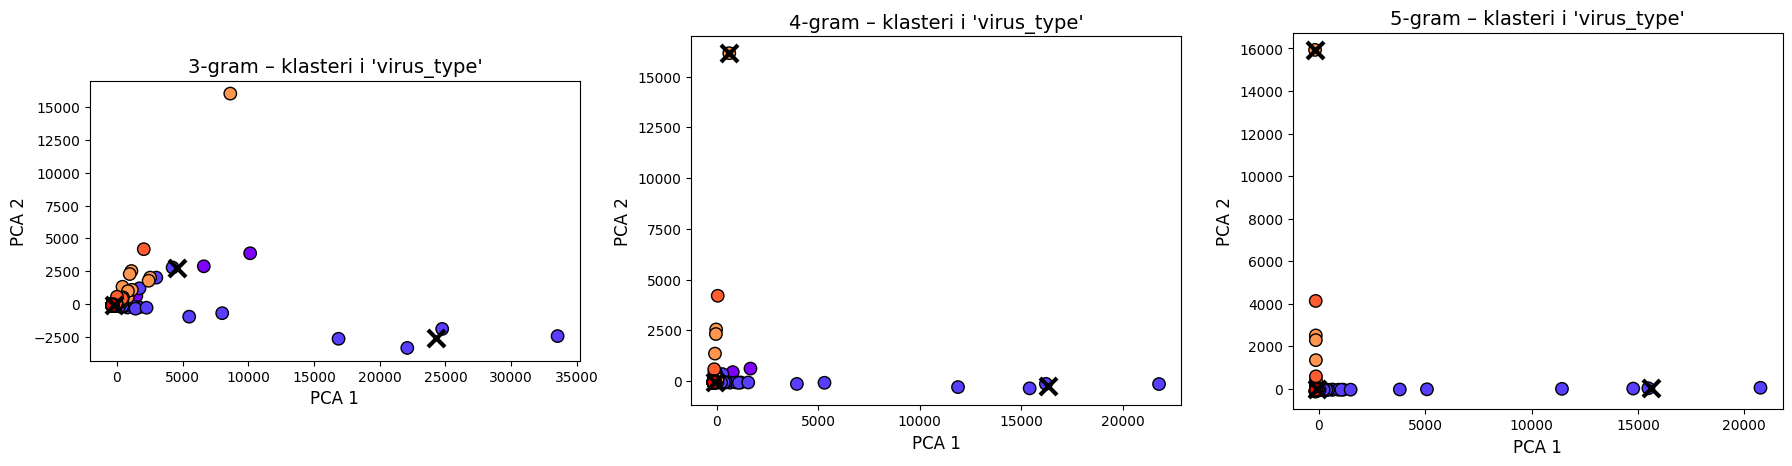

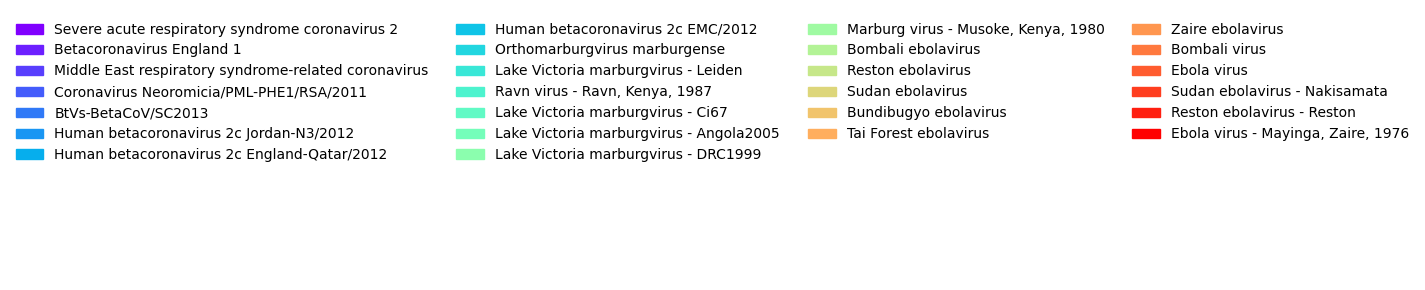

In [44]:
visualize_clusters_only(datasets, label_key="virus_type", k=3)
draw_legend_for_labels(datasets, label_key="virus_type")

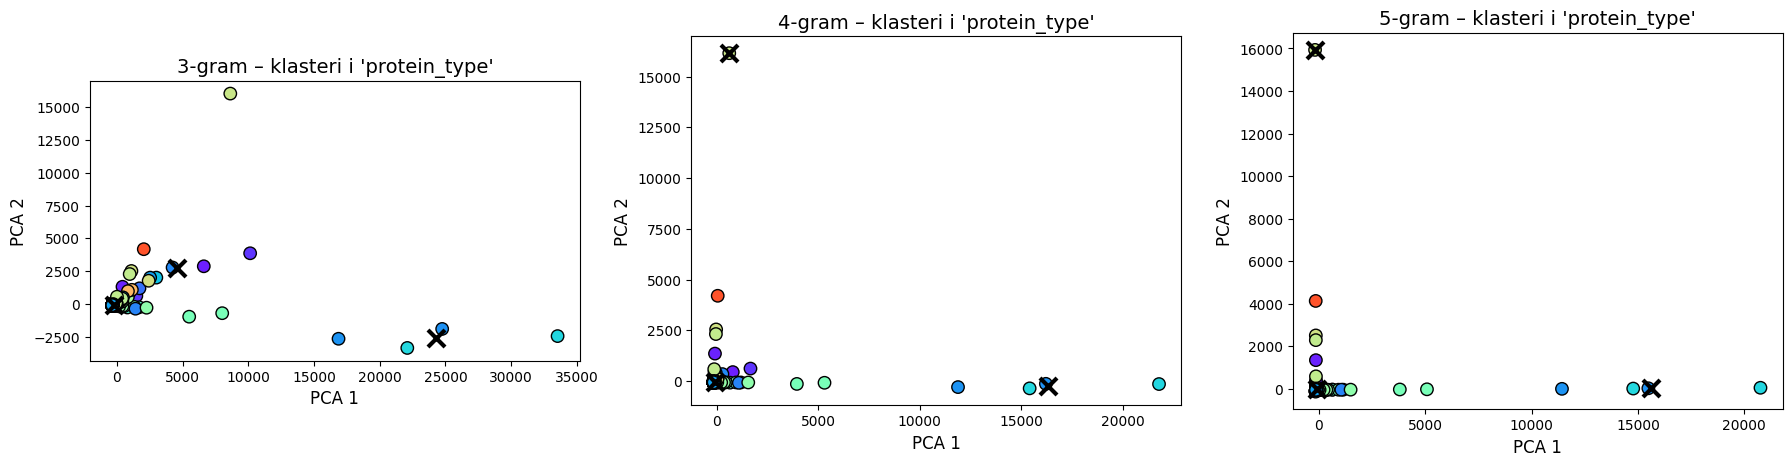

In [45]:
visualize_clusters_only(datasets, label_key="protein_type", k=3)

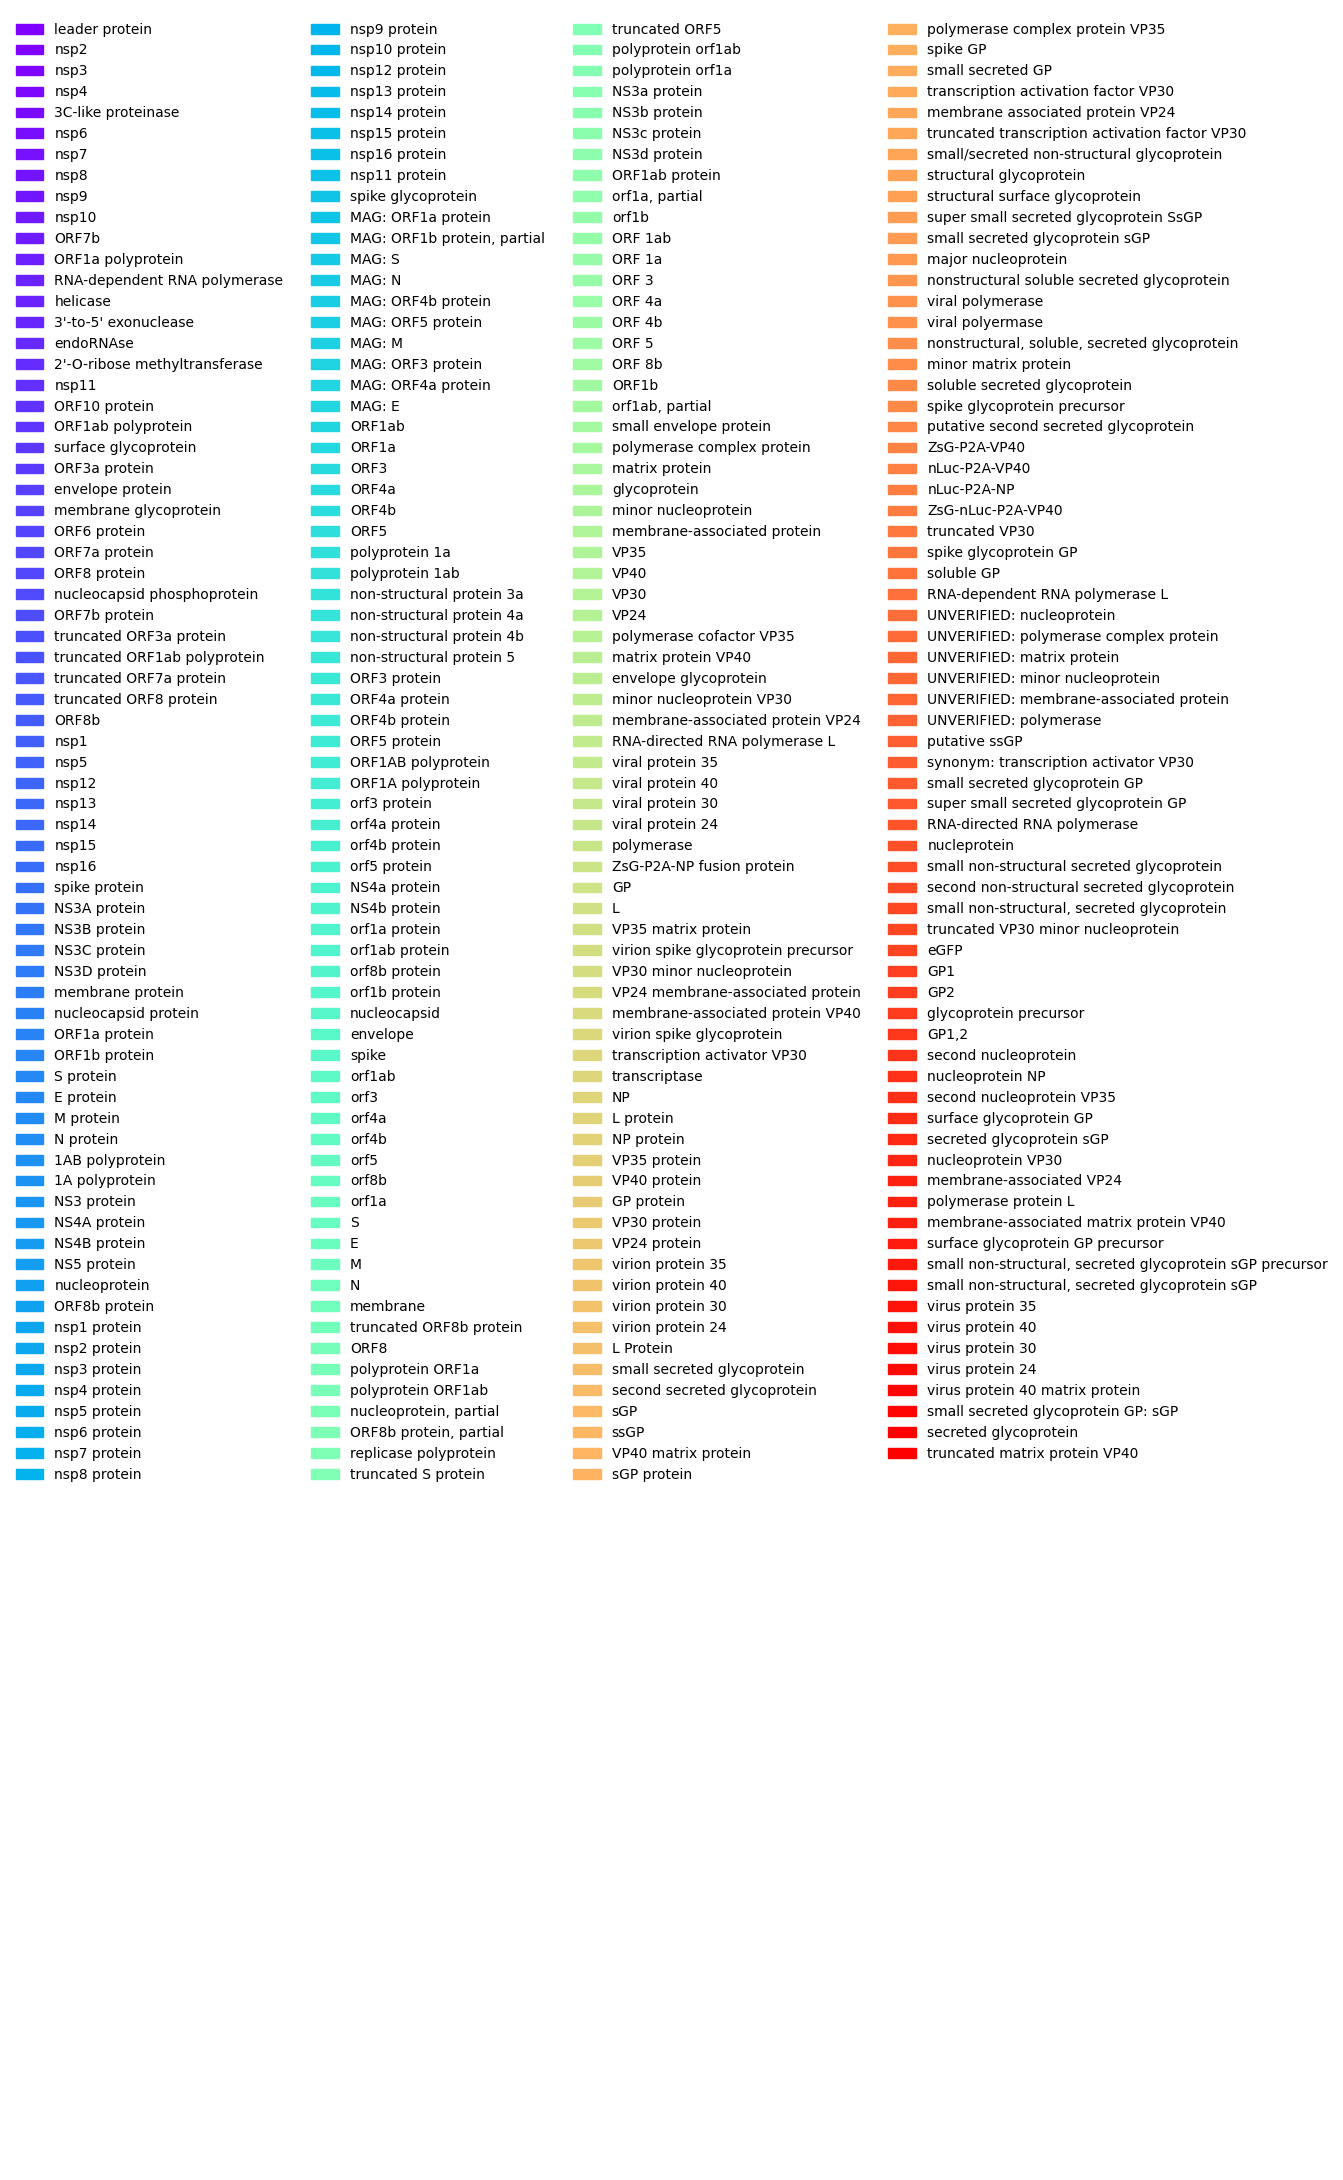

In [46]:
draw_legend_for_labels(datasets, label_key="protein_type")

In [91]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

def plot_dendrograms_simplified(datasets):
    n_plots = len(datasets)
    fig, axs = plt.subplots(n_plots, 1, figsize=(20, 5 * n_plots))  # više širine
    if n_plots == 1:
        axs = [axs]

    for ax, (label, df) in zip(axs, datasets.items()):
        data_numeric = df.iloc[:, 2:].values

        Z = linkage(data_numeric, method='ward')

        dendrogram(
            Z,
            ax=ax,
            truncate_mode='level', 
            p=6,                     
            labels=None,            
            leaf_rotation=90,
            leaf_font_size=6,
            show_contracted=True,
            show_leaf_counts=True,     
            distance_sort='descending' 
        )

        ax.set_title(f"Simplified Dendrogram - {label}", fontsize=14)
        ax.set_ylabel("Distance")

    plt.tight_layout()
    plt.show()

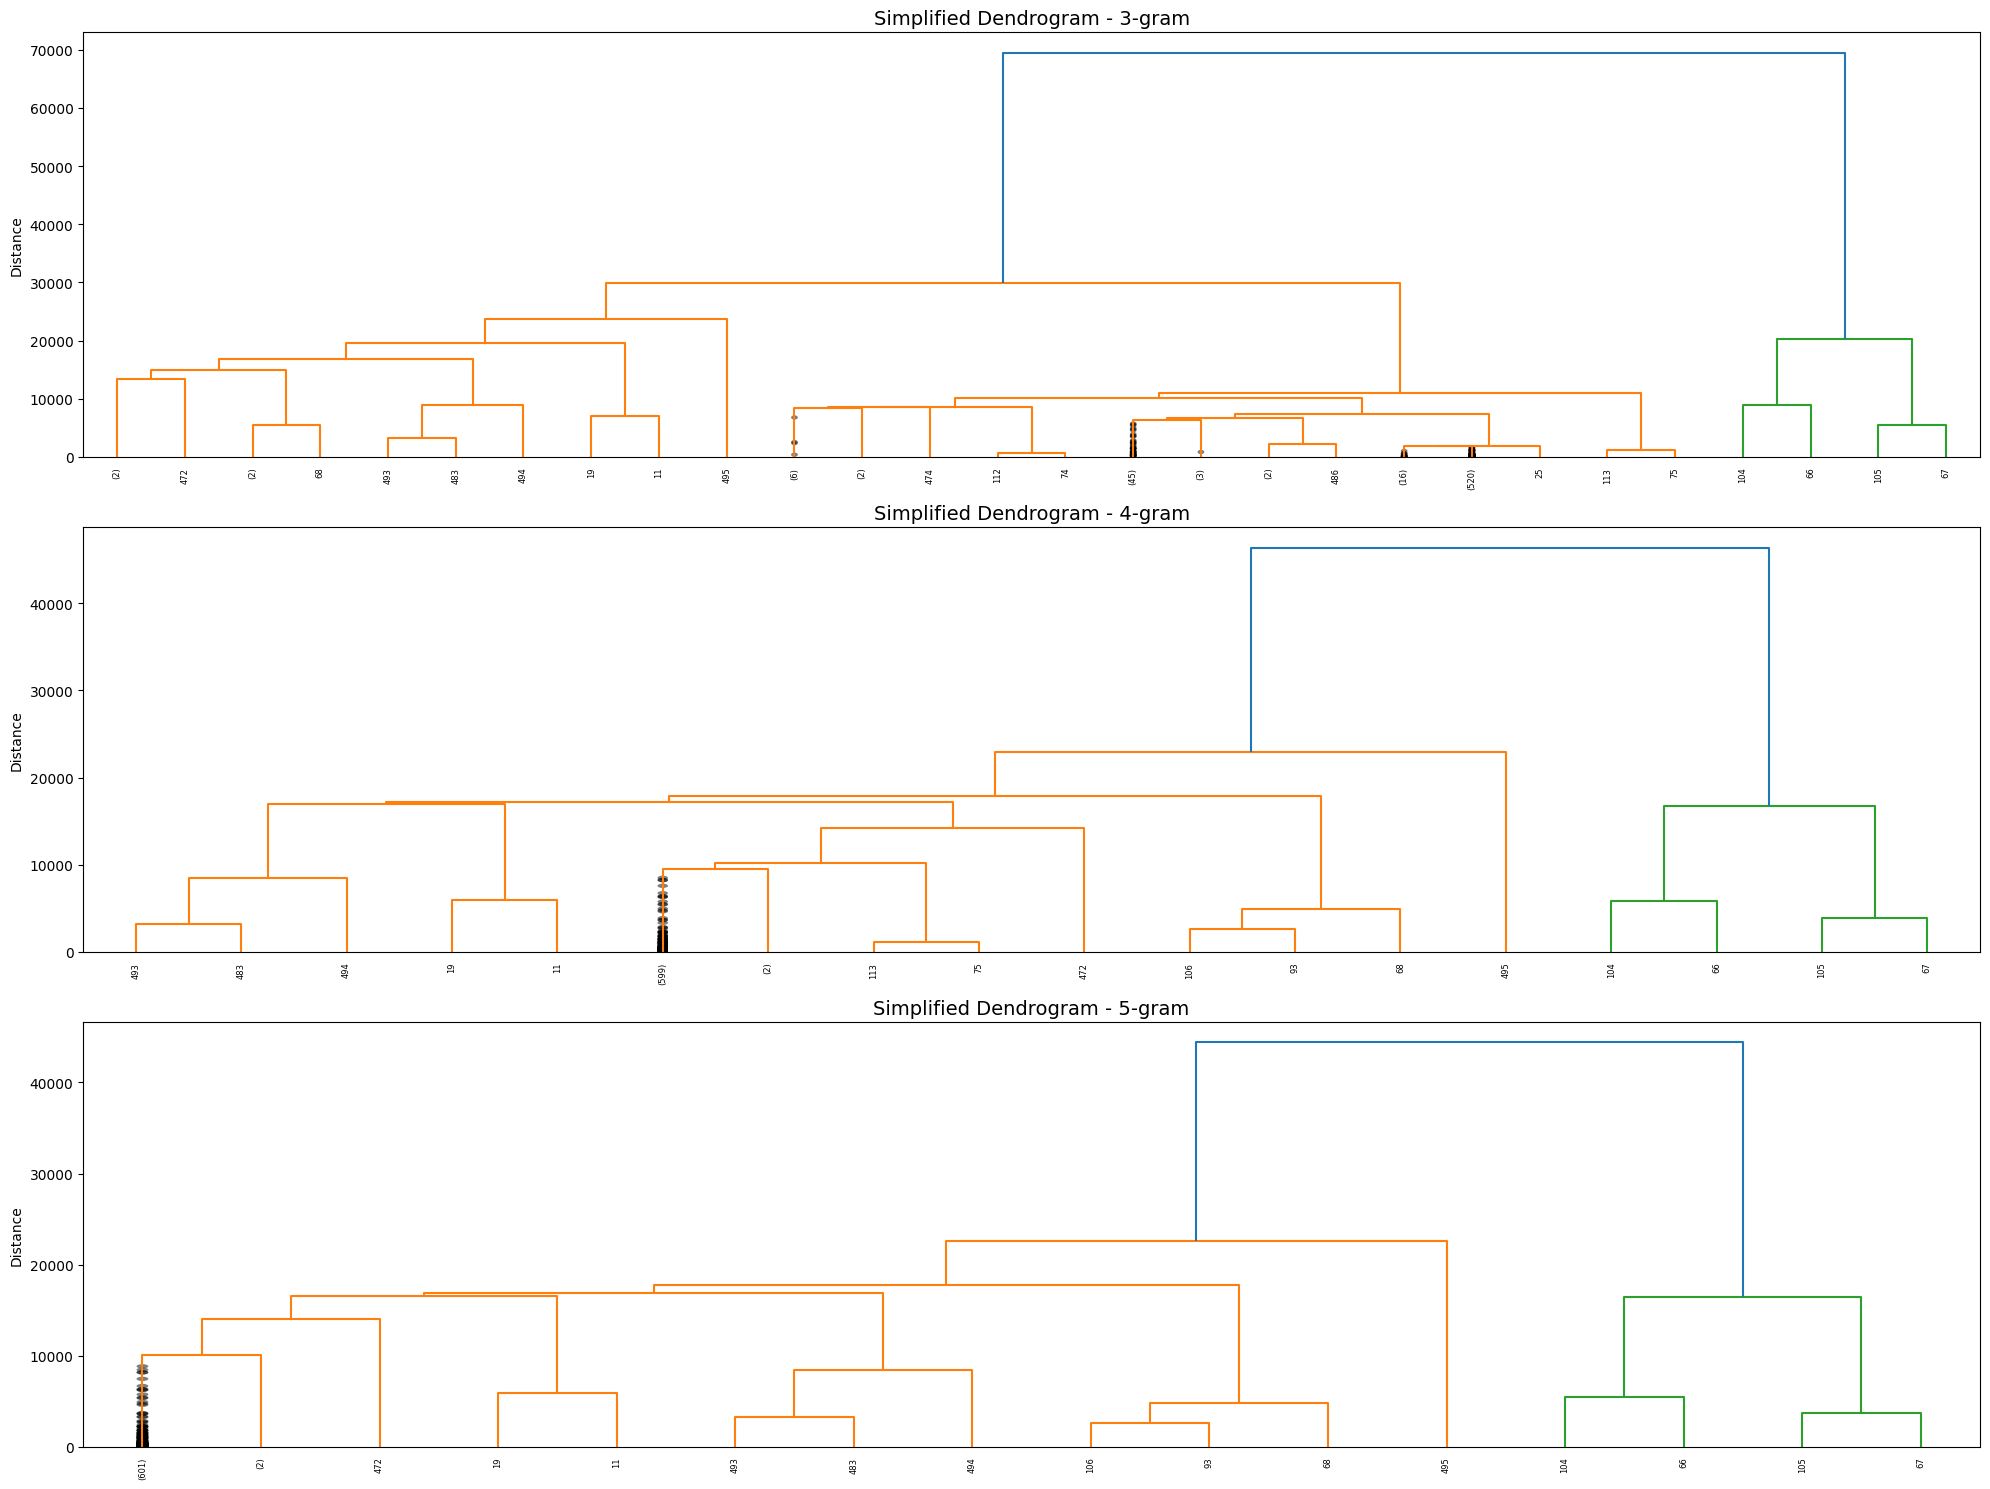

In [92]:
plot_dendrograms_simplified(datasets)

# SOM

In [1]:
from minisom import MiniSom
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def som(datasets, label_column='virus_type', som_x=15, som_y=15, iterations=1000):
    """
    Trains and visualizes SOMs on amino acid n-gram datasets.
    Colors are based on an external label column (e.g., virus_type or protein_type).
    """
    results = []
    fig, axes = plt.subplots(len(datasets), 2, figsize=(12, 5 * len(datasets)))

    if len(datasets) == 1:
        axes = np.expand_dims(axes, axis=0)  # Ensure 2D axes indexing

    for i, (ngram, df) in enumerate(datasets.items()):
        labels = df[label_column].values
        features = df.drop(columns=['virus_type', 'protein_type']).values

        # Standardize feature data
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        # Train SOM
        som = MiniSom(x=som_x, y=som_y, input_len=features_scaled.shape[1], sigma=1.0, learning_rate=0.5)
        som.random_weights_init(features_scaled)
        som.train_random(features_scaled, num_iteration=iterations)

        # Get BMU coordinates
        bmu_coords = np.array([som.winner(x) for x in features_scaled])

        # Map labels to color indices
        unique_labels = sorted(set(labels))
        label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
        color_labels = np.array([label_to_int[label] for label in labels])

        # Save number of unique BMUs (clusters)
        results.append({
            "n_gram": ngram,
            "n_clusters": len(np.unique(bmu_coords, axis=0))
        })

        # Plot 1: U-Matrix
        ax1 = axes[i, 0]
        ax1.set_title(f"SOM U-Matrix ({ngram})")
        im = ax1.pcolor(som.distance_map().T, cmap='bone_r')
        fig.colorbar(im, ax=ax1)

        # Plot 2: Sample positions, colored by external label
        ax2 = axes[i, 1]
        ax2.set_title(f"SOM Colored by {label_column} ({ngram})")
        scatter = ax2.scatter(bmu_coords[:, 0], bmu_coords[:, 1], c=color_labels, cmap='tab10', s=40)
        ax2.set_xlim(0, som_x)
        ax2.set_ylim(0, som_y)
        ax2.legend(handles=scatter.legend_elements()[0], labels=unique_labels, title=label_column)

    plt.tight_layout()
    plt.show()

    return results

In [3]:
df3 = pd.read_csv("../csv_data/3gram_matrix_amino_acid_combined.csv")
df4 = pd.read_csv("../csv_data/4gram_matrix_amino_acid_combined.csv")
df5 = pd.read_csv("../csv_data/5gram_matrix_amino_acid_combined.csv")
datasets = {"3-gram": df3, "4-gram": df4, "5-gram": df5}

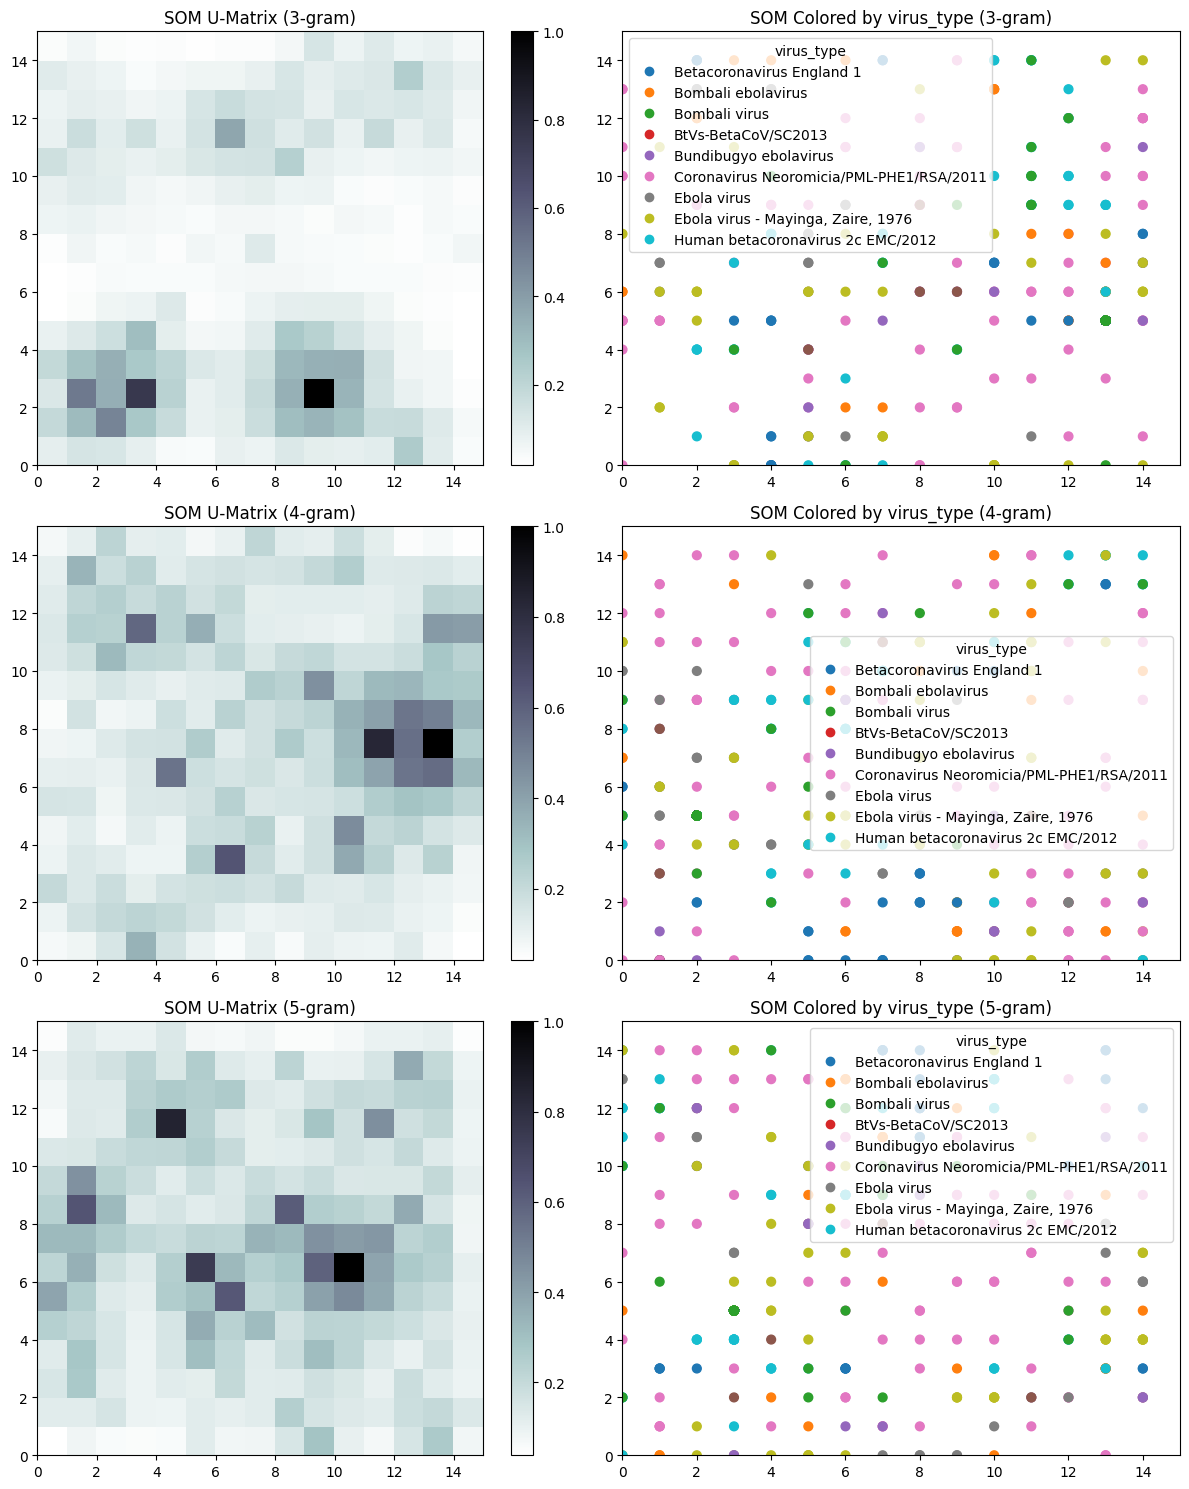

[{'n_gram': '3-gram', 'n_clusters': 132},
 {'n_gram': '4-gram', 'n_clusters': 159},
 {'n_gram': '5-gram', 'n_clusters': 160}]

In [4]:
som(datasets, label_column='virus_type')

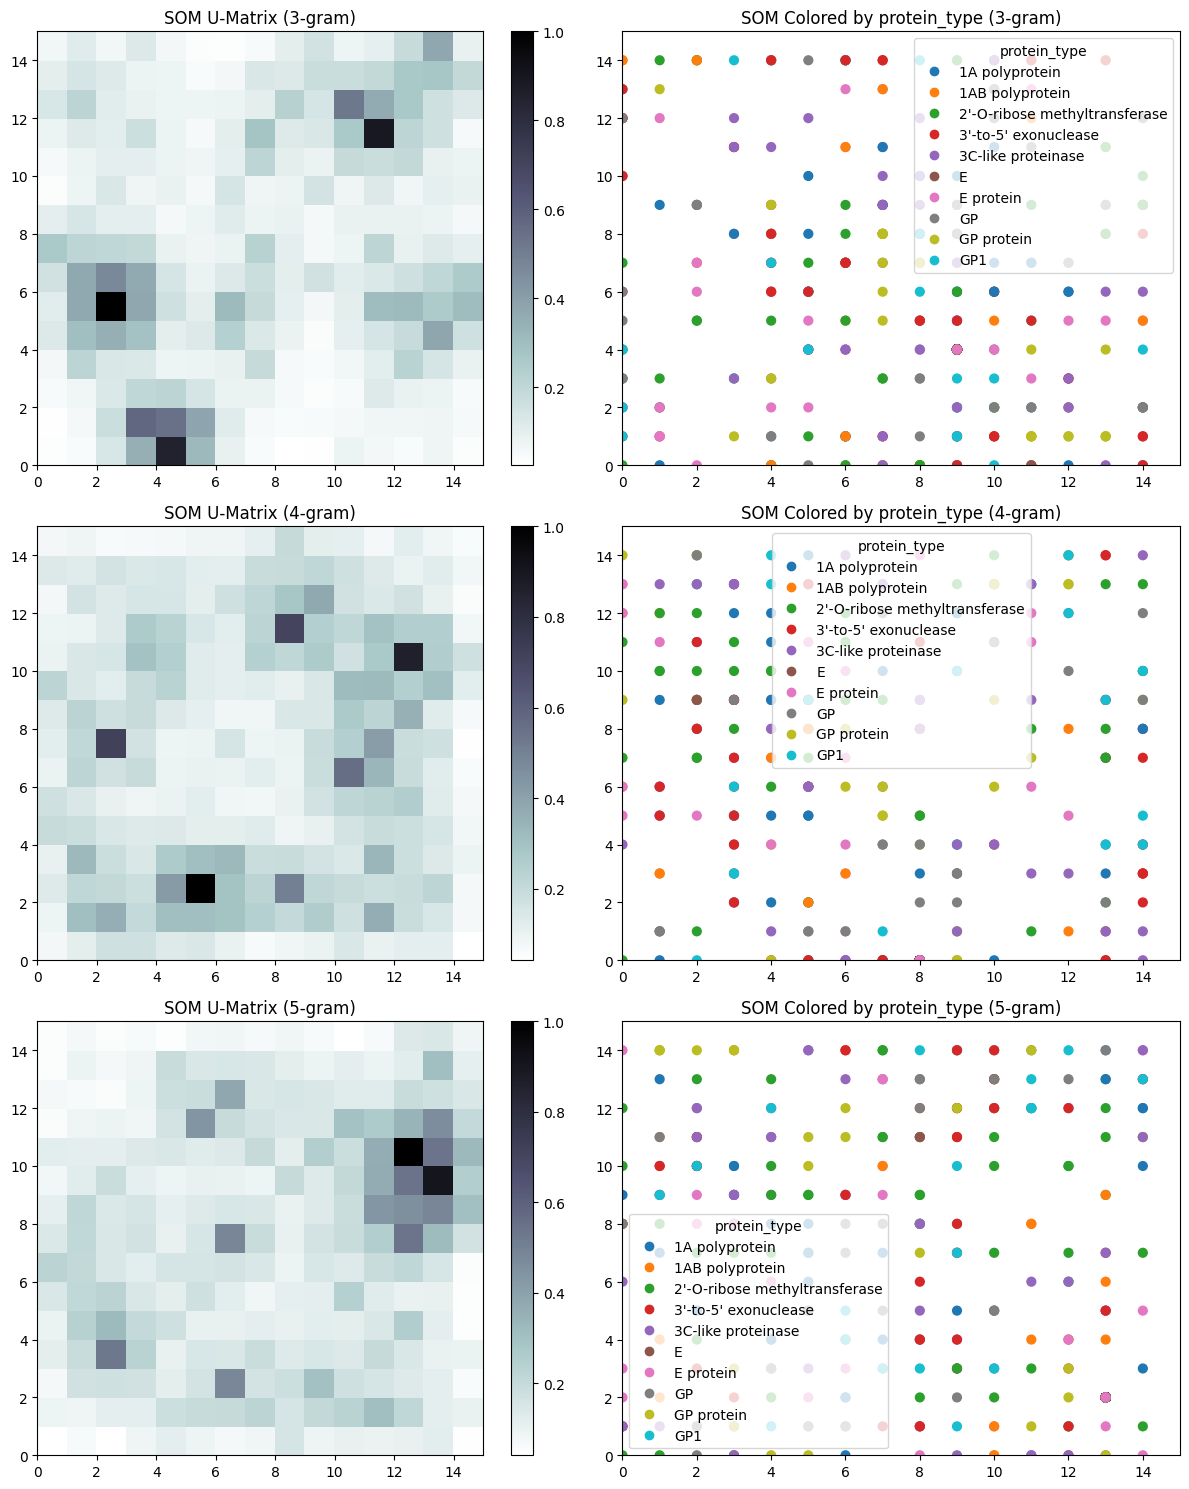

[{'n_gram': '3-gram', 'n_clusters': 150},
 {'n_gram': '4-gram', 'n_clusters': 153},
 {'n_gram': '5-gram', 'n_clusters': 171}]

In [5]:
som(datasets, label_column='protein_type')